Trying to design a second magnet for the small BlueFors fridge.

In [50]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

In [142]:
def area_bisected_circle(R, x):
    # angles are in radians
    theta = np.arccos(x/R)
    triangle_area = x*R*np.sin(theta)
    pie_area = np.pi*(R**2)*(1 - theta/(np.pi))
    return pie_area+triangle_area

In [152]:
# the area avalible for the magnet coils
print "{0:.1f} mm^2".format(area_bisected_circle(28.5, 23.5)-area_bisected_circle(28.5, 8.5))

689.1 mm^2


This is an approximately trapezoidal slice out of a circle. The sides have lengths...

In [153]:
print "short side = {0:.1f} mm, long side = {1:.1f} mm, center = {2} mm".format(
    2*28.5*np.sin(np.arccos(23.5/28.5)), 2*28.5*np.sin(np.arccos(8.5/28.5)), 23.5-8.5)

short side = 32.2 mm, long side = 54.4 mm, center = 15.0 mm


Ok. to take some guess at how many windings will fit I need to guess at the inner diameter of the coil. If a device is about 10mm square, let's say 25mm for the magnet coil.

In [161]:
coil_area = (689.1-25*15)/2
wire_diameter = 0.33
wire_area = np.pi*(wire_diameter/2)**2
N = coil_area/wire_area*0.75
print "N = {0:.0f}".format(N)

N = 1377


That is quite a large number of coils.

Let's call it 1350, just to be safe. And now we can estimate some fields. First, let's assume the coils have a square cross section with the same area that I have calculated here, so N and L remain constant for the solenoid.

In [155]:
print "approximate width of coils with L=15mm ~ {0:.1f} mm".format(coil_area/15.0)

approximate width of coils with L=15mm ~ 10.5 mm


Following the math at this link to determin the field along the solenoid axis: http://nbviewer.jupyter.org/github/tiggerntatie/emagnet-py/blob/master/solenoids/solenoid.ipynb 

The field from the solenoid is:

$B = \frac {\mu_o i n}{2 (r_2 - r_1)} \left [  x_2 \ln \left ( \frac {\sqrt{r_2^2 + x_2^2} + r_2}{\sqrt{r_1^2 + x_2^2} + r_1} \right ) - x_1 \ln \left ( \frac {\sqrt{r_2^2 + x_1^2} + r_2}{\sqrt{r_1^2 + x_1^2} + r_1} \right ) \right ]$

In [146]:
# this is going to get ugly
# need to calculate the axial component and radial component
# make color plots of each

# SI units for this
eps = 1e-7 # machine error
mu0 = 1.25e-6 # permeability of free space
 
def B_on_axis_general(x1, x2, I, n, r1, r2):
    B0 = mu0*I*n/(2.0*(r2-r1))
    B1 = x2*np.log((np.sqrt(r2**2+x2**2)+r2)/(np.sqrt(r1**2+x2**2)+r1))
    B2 = x1*np.log((np.sqrt(r2**2+x1**2)+r2)/(np.sqrt(r1**2+x1**2)+r1))
    return B0*(B1-B2)

def B_on_axis(x, I, L, N, r1, r2):
    x2 = x + L/2.0
    x1 = x - L/2.0
    n = N/L
    return b_on_axis_general(x1, x2, I, n, r1, r2)

def eps2(alpha, beta):
    c1 = 1.0/(1+beta**2)
    c3 = alpha**2/(alpha**2 + beta**2)
    c5 = np.log((alpha + np.sqrt(alpha**2 + beta**2))/(1 + np.sqrt(1 + beta**2)))
    return (1/(2*(beta**2)*c5))*(pow(c1, 3/2)-pow(c3,3/2))

def eps4(alpha, beta):
    c1 = 1.0/(1+beta**2)
    c2 = (beta**2)/(1 + beta**2)
    c3 = (alpha**2)/(alpha**2 + beta**2)
    c4 = (beta**2)/(alpha**2 + beta**2)
    c5 = np.log((alpha + np.sqrt(alpha**2 + beta**2))/(1 + np.sqrt(1 + beta**2)))
    e0 = 1/(12*(beta**4)*c5)
    e1 = pow(c1, 3/2)*(1 + (3/2)*c2 + (15/2)*c2**2)
    e2 = pow(c3, 3/2)*(1 + (3/2)*c4 + (15/2)*c4**2)
    return e0*(e1-e2)

def rho2(u):
    return (1/2)*(3*u**2 - 1)

def drho2(u, du):
    return 3*u*du

def rho4(u):
    return (1/8)*(35*u**4 - 30*u**2 + 3)

def drho4(u,du):
    return (1/8)*(35*4*u**3 - 30*2*u)*du

def B_off_axis_axial(r, x, I, L, N, r1, r2):
    B0 = b_on_axis(x, I, L, N, r1, r2)
    
    d = np.sqrt(x**2+r**2)
    theta = np.arctan(r/x)
    u = np.cos(theta)
    du = np.sin(theta)
    alpha = r2/r1
    beta = L/(2*r1)

    series = 1.0
    series += eps2(alpha,beta)*((d/r1)**2)*rho2(u)
    series += eps4(alpha,beta)*((d/r1)**4)*rho4(u)
    return series

def B_off_axis_radial(r, x, I, L, N, r1, r2):
    B0 = b_on_axis(x, I, L, N, r1, r2)
    
    d = np.sqrt(x**2+r**2)
    theta = np.arctan(r/x)
    u = np.cos(theta)
    du = np.sin(theta)
    alpha = r2/r1
    beta = L/(2*r1)

    series = eps2(alpha,beta)*((d/r1)**2)*drho2(u, du)
    series += eps4(alpha,beta)*((d/r1)**4)*drho4(u, du)
    return series

(0, 30)

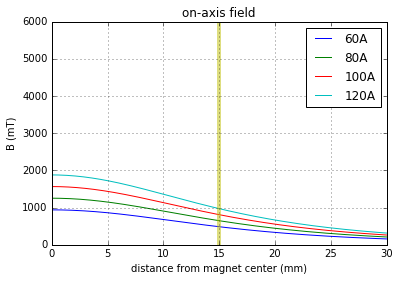

In [202]:
# sample lives at x=15 in this sketch
x = np.linspace(0,30e-3, 200)
fig, ax = plt.subplots(1,1)
for I in [60, 80, 100, 120]:
    ax.plot(x*1000, 1000*b_on_axis(x, I, 12e-3, 500, 15.5e-3, 23.0e-3), label='{0}A'.format(I))
ax.plot(np.ones(200)*15, np.linspace(0,6000, 200), 'y', lw=4, alpha=0.5)
ax.grid()
ax.legend()
ax.set_ylabel('B (mT)')
ax.set_xlabel("distance from magnet center (mm)")
ax.set_title("on-axis field")
ax.set_xlim(0, 30)
# ax.set_ylim(0, 1250)

Cool. Now look at the radial dependence of the axial field

(0.8, 1.1)

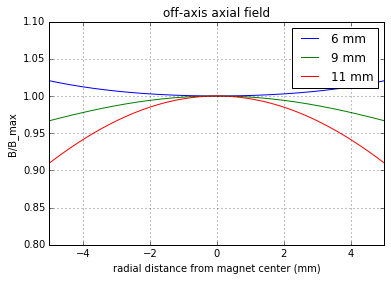

In [229]:
# sample lives at x=15 in this sketch
r = np.linspace(-12e-3,12e-3, 200) # expansion only valid near center of magnet, this is pushing it
fig, ax = plt.subplots(1,1)
for d in [6, 9 , 11]:
    B = B_off_axis_axial(r, d*1e-3, 60, 7.6e-3, 500, 15.5e-3, 23.0e-3)
    axial_max = B[100]
    ax.plot(1000*r, B/axial_max, label='{0} mm'.format(d))
# ax.plot(np.ones(200)*15, np.linspace(0,1500, 200), 'y', lw=4, alpha=0.5)
ax.grid()
ax.legend()
ax.set_ylabel('B/B_max')
ax.set_xlabel("radial distance from magnet center (mm)")
ax.set_title("off-axis axial field")
ax.set_xlim(-5, 5)
ax.set_ylim(0.8, 1.1)

And there's the problem.

(0, 1.1)

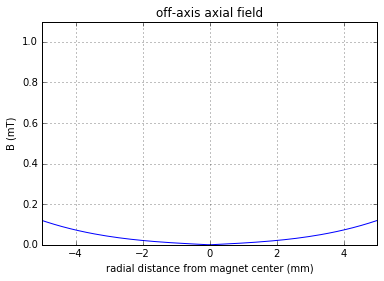

In [186]:
# sample lives at x=15 in this sketch
r = np.linspace(-12e-3,12e-3, 200) # expansion only valid near center of magnet, this is pushing it
fig, ax = plt.subplots(1,1)
B = B_off_axis_radial(r, 12e-3, 60, 17e-3, 1350, 18e-3, 23.0e-3)
ax.plot(1000*r, np.abs(B)/axial_max)
# ax.plot(np.ones(200)*15, np.linspace(0,1500, 200), 'y', lw=4, alpha=0.5)
ax.grid()
ax.set_ylabel('B (mT)')
ax.set_xlabel("radial distance from magnet center (mm)")
ax.set_title("off-axis axial field")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 1.1)
# ax.set_ylim(0, 1250)

This approximation is... fine. It might not be useful, but it gives roughly the right results.

(0, 3000)

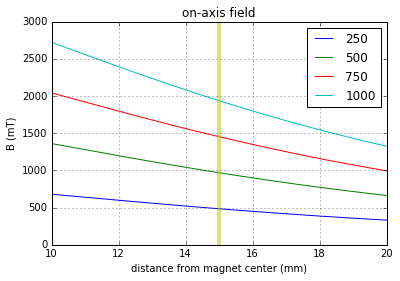

In [230]:
# sample lives at x=15 in this sketch
x = np.linspace(0,30e-3, 200)
fig, ax = plt.subplots(1,1)
for N in [250, 500, 750, 1000]:
    ax.plot(x*1000, 1000*b_on_axis(x, I, 11e-3, N, 15.5e-3, 23.0e-3), label='{0}'.format(N))
ax.plot(np.ones(200)*15, np.linspace(0,6000, 200), 'y', lw=4, alpha=0.5)
ax.grid()
ax.legend()
ax.set_ylabel('B (mT)')
ax.set_xlabel("distance from magnet center (mm)")
ax.set_title("on-axis field")
ax.set_xlim(10, 20)
ax.set_ylim(0, 3000)

Based on that, let's say we go with N=500. 

In [201]:
N = 500
wire_diameter = 0.33
wire_area = np.pi*(wire_diameter/2)**2
cross_section = wire_area*N/0.75
print "the magnet cross section for {0:d} turns is {1:.1f} mm".format(N, cross_section)
print "that is a square with {0:.1f} mm sides, or a circle with {1:.1f} mm diameter".format(
        np.sqrt(cross_section), np.sqrt(4*cross_section/np.pi))

the magnet cross section for 500 turns is 57.0 mm
that is a square with 7.6 mm sides, or a circle with 8.5 mm diameter


The questions remaining are... How much force does this put on any structural support? What type of wire is best (single or multiple filament)? Can I push the magnet any closer to the sample?

In [207]:
60/wire_area*0.75

526.1320432789928